In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Collecting

In [1]:
pip install dtw-python

     |████████████████████████████████| 299 kB 1.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tslearn

In [ ]:
# Libraries
import pandas as pd
import numpy as np
#from numpy import genfromtxt
pd.options.mode.chained_assignment = None
from sklearn import preprocessing
from dtw import *
import time

# Reading data - fetching TRAIN.csv data from the long version

In [4]:
#lenth_of_line = 6695 # can be automated
#path = "/kaggle/input/starcraft-2-player-prediction-challenge-2020/TRAIN_LONG.CSV"
path = "./data/TRAIN_LONG.CSV"
df_train_tmp = pd.read_csv(path, error_bad_lines=False, warn_bad_lines=False)
lenth_of_line = df_train_tmp.shape[1]
print ("lenth_of_line", lenth_of_line)

colnames = list()
colnames.append("id")
colnames.append("game_type")
for i in range (lenth_of_line-2):
    colnames.append("move"+str(i))
len (colnames)

df_train = pd.read_csv(path,names=colnames, header=None, error_bad_lines=False, warn_bad_lines=False)
n_training_games = df_train.shape[0]
print ("n_training_games", n_training_games)

/opt/anaconda3/envs/pyTorch_projets/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6427,6428,6429,6430,6431,6432,6433,6434,6435,6436,6437,6438,6439,6440,6441,6442,6443,6444,6445,6446,6447,6448,6449,6450,6451,6452,6453,6454,6455,6456,6457,6458,6459,6460,6461,6462,6463,6464,6465,6466,6467,6468,6469,6470,6471,6472,6473,6474,6475,6476,6477,6478,6479,6480,6481,6482,6483,6484,6485,6486,6487,6488,6489,6490,6491,6492,6493,6494,6495,6496,6497,6498,6499,6500,6501,6502,6503,6504,6505,6506,6507,6508,6509,6510,6511,6512,6513,6514,6515,6516,6517,6518,6519,6520,6521,6522,6523,6524,6525,6526,6527,6528,6529,6530,6531,6532,6533,6534,6535,6536,6537,6538,6539,6540,6541,6542,6543,6544,6545,6546,6547,6548,6549,6550,6551,6552,6553,6554,6555,6556,6557,6558,6559,6560,6561,6562,6563,6564,6565,6566,6567,6568,6569,6570,6571,6572,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582,6583,6584,6585,6586,6587,6588,6589,6590,6591,6592,6593,6594,6595,6596,6597,6598,6599,6600,6601

lenth_of_line 6695
n_training_games 3052


In [5]:
df_train.head(3)

,id,game_type,move0,move1,move2,move3,move4,move5,move6,move7,...,move6683,move6684,move6685,move6686,move6687,move6688,move6689,move6690,move6691,move6692
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,6:CameraEvent:26.0:155.7578125,16:SelectionEvent:Nexus,18:BasicCommandEvent:TrainProbe,21:SelectionEvent:Probe;Probe,25:TargetPointCommandEvent:27.7021484375:162.0...,32:SelectionEvent:Probe,33:TargetUnitCommandEvent:CAbil:MineralField,43:SelectionEvent:Probe,...,26431:TargetPointCommandEvent:46.4304199219:14...,26434:TargetPointCommandEvent:46.6022949219:14...,26439:ControlGroupEvent:3:2,26439:CameraEvent:59.4609375:144.640625,26441:CameraEvent:59.4609375:140.4140625,26441:ControlGroupEvent:4:2,26442:CameraEvent:59.4609375:137.7265625,26446:ControlGroupEvent:5:2,26449:ControlGroupEvent:6:2,"26476:ChatEvent:""gg"""
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,6:CameraEvent:158.0:24.7578125,21:SelectionEvent:Probe;Probe,22:TargetUnitCommandEvent:CAbil:MineralField,28:SelectionEvent:Nexus,29:BasicCommandEvent:TrainProbe,32:SelectionEvent:Probe,33:TargetUnitCommandEvent:CAbil:MineralField,40:SelectionEvent:Nexus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,4:CameraEvent:140.0:24.7578125,14:SelectionEvent:Nexus,16:BasicCommandEvent:TrainProbe,18:SelectionEvent:Probe;Probe,21:TargetUnitCommandEvent:CAbil:MineralField,28:SelectionEvent:Probe,30:TargetUnitCommandEvent:CAbil:MineralField,34:TargetUnitCommandEvent:CAbil:MineralField,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning Training Data

In [6]:
# Cleaning Training Data by removing all games with no move at all (false starts most likely)
#df_train.dropna(how='all')
df_train.dropna(subset=['move0'], inplace=True)
df_train.reset_index(drop=True, inplace = True)
df_train.tail(3)

,id,game_type,move0,move1,move2,move3,move4,move5,move6,move7,...,move6683,move6684,move6685,move6686,move6687,move6688,move6689,move6690,move6691,move6692
3044,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,4:CameraEvent:158.0:155.7578125,14:SelectionEvent:OrbitalCommandFlying,14:BasicCommandEvent:TrainSCV,18:SelectionEvent:SCV,20:TargetPointCommandEvent:156.681396484:160.1...,24:TargetUnitCommandEvent:CAbil:MineralField,30:SelectionEvent:OrbitalCommandFlying,34:TargetUnitCommandEvent:CAbil:MineralField,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3045,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,5:CameraEvent:26.99609375:134.7578125,14:SelectionEvent:OrbitalCommand,14:BasicCommandEvent:TrainSCV,18:SelectionEvent:SCV,21:TargetUnitCommandEvent:CAbil:MineralField,25:ControlGroupEvent:1:0,28:SelectionEvent:OrbitalCommand,28:ControlGroupEvent:2:0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3046,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,4:CameraEvent:117.0:21.7578125,17:SelectionEvent:OrbitalCommand,17:BasicCommandEvent:TrainSCV,21:SelectionEvent:SCV,21:TargetPointCommandEvent:115.664550781:20.94...,25:TargetUnitCommandEvent:CAbil:MineralField,30:SelectionEvent:OrbitalCommand,36:ControlGroupEvent:1:0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Reading data - fetching TEST.csv data

In [9]:
# Reading data - fetching TEST.csv data
#path = "/kaggle/input/starcraft-2-player-prediction-challenge-2020/TEST_LONG.CSV"
path = "./data/TEST_LONG.CSV"
#lenth_of_line = 3446 # can be automated
df_train_tmp = pd.read_csv(path, error_bad_lines=False, warn_bad_lines=False)
lenth_of_line = df_train_tmp.shape[1]
print ("lenth_of_line", lenth_of_line)
colnames = list()
colnames.append("game_type")
for i in range (lenth_of_line-1):
    colnames.append("move"+str(i))
len (colnames)

df_test = pd.read_csv(path,names=colnames, header=None, error_bad_lines=False, warn_bad_lines=False)
n_testing_games = df_test.shape[0]
print ("n_testing_games", n_testing_games)

/opt/anaconda3/envs/pyTorch_projets/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5810,5811,5812,5813,5814,5815,5816,5817,5818,5819,5820,5821,5822,5823,5824,5825,5826,5827,5828) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


lenth_of_line 5829
n_testing_games 340


In [10]:
df_test.tail(3)

,game_type,move0,move1,move2,move3,move4,move5,move6,move7,move8,...,move5818,move5819,move5820,move5821,move5822,move5823,move5824,move5825,move5826,move5827
337,Terran,4:CameraEvent:98.0:155.7578125,14:SelectionEvent:OrbitalCommand,16:BasicCommandEvent:TrainSCV,18:SelectionEvent:SCV,21:TargetUnitCommandEvent:CAbil:MineralField,28:ControlGroupEvent:1:0,30:SelectionEvent:OrbitalCommand,32:ControlGroupEvent:2:0,36:SelectionEvent:SCV;SCV;SCV;SCV;SCV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338,Terran,4:CameraEvent:22.0:15.7578125,14:SelectionEvent:OrbitalCommand,14:BasicCommandEvent:TrainSCV,18:SelectionEvent:SCV,21:TargetPointCommandEvent:19.6926269531:19.27...,26:TargetPointCommandEvent:18.9331054688:19.65...,28:TargetPointCommandEvent:18.6674804688:19.65...,32:TargetUnitCommandEvent:CAbil:MineralField,37:SelectionEvent:OrbitalCommand,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,Terran,5:CameraEvent:146.0:19.7578125,16:SelectionEvent:OrbitalCommand,16:BasicCommandEvent:TrainSCV,20:SelectionEvent:SCV,22:TargetUnitCommandEvent:CAbil:MineralField,36:ControlGroupEvent:1:0,37:SelectionEvent:OrbitalCommand,40:ControlGroupEvent:2:0,45:SelectionEvent:SCV;SCV;SCV;SCV;SCV;SCV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Extracting Time Series
- To be able to compare time series together we need to give them the same time interval between values.
- To do so we fill empty values with -1 as a filler.
- It is much more difficult to compute the difference between two time series if they have irregular time intervals.
- A problem with this encoding is that hotkey 9 is farther to 1 that 0 is to 1 etc. (Catergical values are being compared)

In [11]:
# imports
from tqdm import tqdm

> ## Generating time series with only the hot key number

In [12]:
#action = df.iloc[game_index]["move"+str(move_number)]
# 

def gererate_time_series(df, ts_size = 960):
    #print ("herrre")
    n_games,len_line= df.shape
    #print (n_games,len_line)
    time_series = []
    for index,data in tqdm(df.iterrows()):
        #print ("here0")
        #time_serie = np.zeros(ts_size)
        time_serie = [-1]*ts_size
        for move_number in range(len_line-1):
            move = data["move"+str(move_number)]
            if move == move:
                #print ("here1")
                #print (data["move"+str(move_number)])
                move_split = move.split(":")
                if len(move_split)>=2:
                    #print("here2")
                    #print(data_split[0])
                    #print (data_split)
                    frame = int(move_split[0])
                    event = move_split[1]
                    if frame < ts_size:
                        #print ("here3") 
                        if event == "ControlGroupEvent":
                            event_hotkey = int(move_split[2])
                            event_update_type = move_split[3]
                            time_serie[frame] = event_hotkey
                            #print(event_hotkey)
                            #print (frame)
                            #print(move)
                    else:
                        break
        #print("-------------------------------")
        time_series.append(time_serie) 
    return time_series

In [13]:
train_time_series = gererate_time_series(df_train.drop(columns = ["id"]),960)

3047it [00:14, 207.29it/s]


In [14]:
test_time_series = gererate_time_series(df_test,960)

340it [00:01, 207.68it/s]


## Generating time series with only the hot key number
Encoding:
- Ex: 12 -> 1 + 0.2*2 -> 1.4
- Ex: 30 -> 3 + 0.2*0 -> 3.0
- Ex: 91 -> 9 + 0.2*1 -> 9.1

In [15]:
## Generating time series with only the hot key number

def gererate_time_series_2(df, ts_size = 960):
    #print ("herrre")
    n_games,len_line= df.shape
    #print (n_games,len_line)
    time_series = []
    for index,data in tqdm(df.iterrows()):
        #print ("here0")
        #time_serie = np.zeros(ts_size)
        time_serie = [-1]*ts_size
        for move_number in range(len_line-1):
            move = data["move"+str(move_number)]
            if move == move:
                #print ("here1")
                #print (data["move"+str(move_number)])
                move_split = move.split(":")
                if len(move_split)>=2:
                    #print("here2")
                    #print(data_split[0])
                    #print (data_split)
                    frame = int(move_split[0])
                    event = move_split[1]
                    if frame < ts_size:
                        #print ("here3") 
                        if event == "ControlGroupEvent":
                            event_hotkey = int(move_split[2])
                            event_update_type = move_split[3]
                            time_serie[frame] = float(event_hotkey) + float(event_update_type)*0.2
                            #print(event_hotkey)
                            #print (frame)
                            #print(move)
                    else:
                        break
        #print("-------------------------------")
        time_series.append(time_serie) 
    return time_series 

In [16]:
train_time_series = gererate_time_series_2(df_train.drop(columns = ["id"]),960)

3047it [00:14, 206.40it/s]


In [17]:
test_time_series = gererate_time_series_2(df_test,960)

340it [00:01, 230.55it/s]


In [18]:
# Train
print("We have", len(train_time_series),"time series in the training data")
print("Each time series is set to be of length:",len(train_time_series[0]),"frames (=1min)") # 16frames/sec
print ("Ex",train_time_series[0][680:700])

We have 3047 time series in the training data
Each time series is set to be of length: 960 frames (=1min)
Ex [-1, -1, -1, -1, -1, 3.4, -1, -1, -1, 3.4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [19]:
# Test
print("We have", len(test_time_series),"time series in the training data")
print("Each time series is set to be of length:",len(test_time_series[0]),"frames (=1min)") # 16frames/sec
print ("Ex",test_time_series[0][680:700])

We have 340 time series in the training data
Each time series is set to be of length: 960 frames (=1min)
Ex [-1, 6.4, -1, -1, -1, -1, -1, 0.4, -1, 6.4, 0.4, 6.4, -1, -1, 0.4, 6.4, -1, -1, -1, -1]


# Data Visualisation

In [20]:
from matplotlib import pyplot as plt

## Plot the first n games of the training set

We see that different games have different signature time series


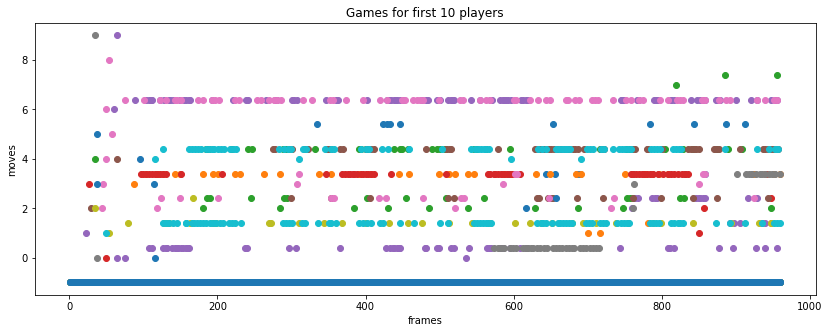

In [21]:
# Plot the first n games
first_games = 10
plt.figure(1,figsize=(14,5))
#player_id = str(df_train['id'][1])
x = range(1,len(train_time_series[0])+1)
ids = list()
for index, data in df_train.iterrows():
    if len(ids)>first_games:
        break
    #print(type(data['id']))
    #print(ids)
    if str(data['id']) not in ids: 
        plt.scatter(x,train_time_series[index])
        ids.append(data['id'])
    
    
    
plt.title("Games for first "+ str(first_games)+" players")
plt.xlabel('frames')
plt.ylabel('moves')
print ("We see that different games have different signature time series")

## Plot all of the games for a given player

Here we see that for a player, The signature similar between games


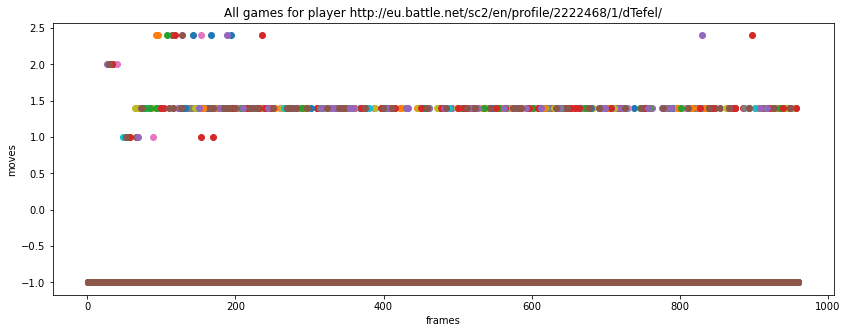

In [22]:
# Plot all of the games for a given player
plt.figure(1,figsize=(14,5))
player_id = str(df_train['id'][50])
x = range(1,len(train_time_series[0])+1)
for index, data in df_train.head(len(train_time_series)).iterrows():
    if data['id'] == player_id:
        plt.scatter(x,train_time_series[index])

plt.title("All games for player "+ player_id)
plt.xlabel('frames')
plt.ylabel('moves')
print ("Here we see that for a player, The signature similar between games")

# Training KNN with tslearn (default metric is DTW)

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

In [ ]:
X = to_time_series_dataset([i for i in train_time_series])
y = list(df_train['id'])[:len(X)]

X_scaled = TimeSeriesScalerMinMax().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

knn = KNeighborsTimeSeriesClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

# Training KNN with DTW

In [23]:
#custom metric
def DTW(a, b):   
    return dtw(a, b, dist_method='euclidean',keep_internals=True).distance

In [24]:
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [26]:
X = train_time_series[:1000]
y = list(df_train['id'])[:len(X)]
print (len(X),len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Train
knn_model = KNeighborsClassifier(metric=DTW, n_neighbors = 1)

## Train with GridSearch
#parameters = {'n_neighbors':[2, 4, 8]}
#knn_model = GridSearchCV(KNeighborsClassifier(metric=DTW), parameters, cv=3, verbose=1)

# fit
print ("start fit")
knn_model.fit(X_train, y_train)

#evaluate
print ("start eval")
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))
#print (knn_model.best_estimator_)
#print (knn_model.best_score_)

1000 1000
start fit
start eval
                                                             precision    recall  f1-score   support

      http://eu.battle.net/sc2/en/profile/1021189/1/Dayshi/       0.00      0.00      0.00         0
       http://eu.battle.net/sc2/en/profile/1058669/1/Happy/       0.50      1.00      0.67         1
    http://eu.battle.net/sc2/en/profile/1143713/1/uThermal/       0.50      0.67      0.57         3
http://eu.battle.net/sc2/en/profile/1173786/1/VPbenQsLivko/       1.00      1.00      1.00         1
    http://eu.battle.net/sc2/en/profile/1430346/1/ShoWTimE/       0.00      0.00      0.00         1
     http://eu.battle.net/sc2/en/profile/2048063/1/AcerBly/       0.00      0.00      0.00         2
    http://eu.battle.net/sc2/en/profile/2101268/1/Stephano/       0.00      0.00      0.00         4
    http://eu.battle.net/sc2/en/profile/2115876/1/FireCake/       0.00      0.00      0.00         0
      http://eu.battle.net/sc2/en/profile/2222468/1/dTefel/

/opt/anaconda3/envs/pyTorch_projets/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pyTorch_projets/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Evaluating the unlabeled testing set - Creating submission file

In [ ]:
#Train
#knn_model = KNeighborsClassifier(metric=DTW, n_neighbors = 1)
print ("fitting model")
#knn_model.fit(train_time_series, list(df_train["id"]))
print ("predicting model")
y_pred = knn_model.predict(test_time_series)

In [ ]:
file_name = "submission7"
df_submission = pd.DataFrame()
df_submission['RowId'] = range(1,len(y_pred)+1)
df_submission['prediction'] = y_pred
df_submission.to_csv('/kaggle/working/'+file_name+'.csv', index = False)
df_submission.head()

# SAX Tutorial

In [ ]:
pip install saxpy

## Simple time series to SAX conversion

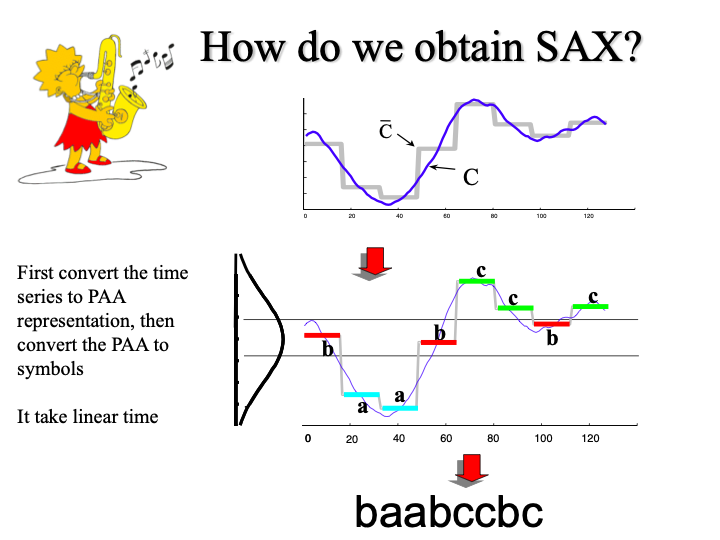

To convert a time series of an arbitrary length to SAX we need to define the alphabet cuts. Saxpy retrieves cuts for a normal alphabet (we use size 3 here) via cuts_for_asize function.

To convert a time series to letters with SAX we use ts_to_string function but not forgetting to z-normalize the input time series (we use Normal alphabet):

In [ ]:
import numpy as np
from saxpy.znorm import znorm
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string

ts_to_string(znorm(np.array([-2, 0, 2, 0, -1])), cuts_for_asize(3))

In order to reduce dimensionality further, the PAA (Piecewise Aggregate Approximation) is usually applied prior to SAX:

In [ ]:
from saxpy.paa import paa

dat = np.array([-2, 0, 2, 0, -1])
dat_znorm = znorm(dat)
dat_paa_3 = paa(dat_znorm, 3)

ts_to_string(dat_paa_3, cuts_for_asize(3))

In [ ]:
import numpy
import matplotlib.pyplot as plt

from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, \
    OneD_SymbolicAggregateApproximation

numpy.random.seed(0)
# Generate a random walk time series
n_ts, sz, d = 1, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset = scaler.fit_transform(dataset)

# PAA transform (and inverse transform) of the data
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(dataset))

# SAX transform
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                     alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(dataset))

# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 8
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)
transformed_data = one_d_sax.fit_transform(dataset)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(transformed_data)

plt.figure()
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(dataset[0].ravel(), "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()

PAA (Piecewise Aggregate Approximation) corresponds to a downsampling of the original time series and, in each segment (segments have fixed size), the mean value is retained.

SAX (Symbolic Aggregate approXimation) builds upon PAA by quantizing the mean value. Quantization boundaries are computed for all symbols to be equiprobable, under a standard normal distribution assumption.

Finally, 1d-SAX is an extension of SAX in which each segment is represented by an affine function (2 parameters per segment are hence quantized: slope and mean value).

# ---------------------MORE VISUALISATION----------------------- 

In [ ]:
#count number of players/labels in training dataset

list_unique_id = np.array(df_train["id"].unique())
print ("there are %d player labels in the training dataset"%len(list_unique_id))

In [ ]:
# [old Code]

# Adding first feature = type of game played
 
# For each id count how many game types he is associated to.
number_players = len(list_unique_id)
game_types = list()
for player_id in list_unique_id:
    
    player_history = df_train[df_train["id"]== player_id]
    game_types.append(len (player_history["game_type"].unique()))
avg = sum(game_types)/number_players
print("average number of types of games played by a player = " +  str(avg))
print(game_types)
print("This shows that a player only plays on one type of game")

In [ ]:
# get information on the length of games

moves_sec = list()
#df_train = df_train.head()

data = df_train.head(1000)
total_moves_list = []
game_times = []
lenth_of_line = df_train.shape[1]
for player_game_index in range (data.shape[0]):
    total_moves = 0
    game_time = 0
    for move_number in range (lenth_of_line-2):
        move = data.iloc[player_game_index]["move"+str(move_number)] #
        #print (move)
        if (not pd.isnull(move)):
            if move[:1] == "t":
                #game_time = int(move[1:])
                game_time += 5 
            else:
                total_moves +=1
    game_time += 0
    game_times.append(game_time)
    total_moves_list.append(total_moves)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.title("hist of game time")
plt.hist(game_times, bins=20)
plt.figure(2)
plt.title("hist of number of moves per game")
plt.hist(total_moves_list, bins=20)
#game_times
limit =50
short_games = [time for time in game_times if time<limit]
print ("Only", len(short_games), "games finish before",limit,"seconds")

In [ ]:
# RACE REPARTITION
races = df_train['game_type'].value_counts()
print(races)
plt = races.plot.bar()

In [ ]:
# number of games per player 
player_counts = df_train['id'].value_counts()
print(player_counts.describe())

# list of unique actions
def find_unique_actions(df):
    unique_actions = set()
    actions = df.shape[0]
    for game_index in range(actions):
        for a in df.iloc[game_index]:
            if not pd.isnull(a) and a[0]!='t':
                unique_actions.add(a)
    return unique_actions

unique_hotkeys = sorted(list(find_unique_actions(df_train.drop(['id','game_type'], inplace=False, axis=1))))
print(unique_hotkeys)

keys = list(set([hotkey[:len(hotkey)-1] for hotkey in unique_hotkeys if 'hotkey' in hotkey]))
print(keys)

def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print("Accuracy:",accuracy)
    return accuracy

# DTW Tutorial

In [ ]:
# https://dynamictimewarping.github.io/python/
# https://dynamictimewarping.github.io/py-api/html/
# https://stats.stackexchange.com/questions/109343/dynamic-time-warping-for-irregular-time-series
from dtw import *
#?dtw
#help(DTW)

In [ ]:
import numpy as np

## A noisy sine wave as query
idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/10.0

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)

## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(query, template, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
print(rabinerJuangStepPattern(6,"c"))
rabinerJuangStepPattern(6,"c").plot()

## And much more!